The cell bellow installs required dependencies if not already met

In [1]:
import sys
!{sys.executable} -m pip install keras
!{sys.executable} -m pip install tensorflow

  Using cached keras-2.6.0-py2.py3-none-any.whl (1.3 MB)
  Attempting uninstall: keras
    Found existing installation: Keras 2.2.4
    Uninstalling Keras-2.2.4:
      Successfully uninstalled Keras-2.2.4
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

plaidml-keras 0.7.0 requires keras==2.2.4, but you'll have keras 2.6.0 which is incompatible.


The cell bellow runs plaidml instead of tensorflow as Keras' backend. This is needed if you wish to run locally using an AMD GPU. for more information [read here](https://github.com/plaidml/plaidml). Otherwhise, ignore this cell

In [13]:
import plaidml.keras
plaidml.keras.install_backend()
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

The cell bellow loads and preprocesses the training and validation data. All sequences are shortened to the first 30s of data (9000 points) and any sequence shorter than that are discared. the training data is also normalised.

In [11]:
import os
import scipy.io
from keras.preprocessing import sequence
import numpy as np

training_data = []
training_labels = []
max_len = 9000

training_dir = os.path.join('..', 'data', 'training')
      
for Class in ['normal', 'af']:
    class_dir = os.path.join(training_dir, Class)
    for file in [os.path.join(class_dir, _) for _ in os.listdir(class_dir) if _.endswith('.mat')]:
        mat_data = scipy.io.loadmat(file)
        sequence = mat_data['val'][0]
        if len(sequence) >= 9000:
          normalised_sequence = (sequence - min(sequence)) / (max(sequence) - min(sequence))
          padded_sequence = normalised_sequence[:max_len]
          training_data.append(padded_sequence)
          training_labels.append(Class)

validation_data = []
validation_labels = []
validation_dir = os.path.join('..', 'data', 'validation')
      
for Class in ['normal', 'af']:
    class_dir = os.path.join(validation_dir, Class)
    for file in [os.path.join(class_dir, _) for _ in os.listdir(class_dir) if _.endswith('.mat')]:
        mat_data = scipy.io.loadmat(file)
        sequence = mat_data['val'][0]
        if len(sequence) >= 9000:
          padded_sequence = sequence[:max_len]
          training_data.append(padded_sequence)
          training_labels.append(Class)
          validation_data.append(padded_sequence)
          validation_labels.append(Class)

print('training data', len(training_data))
print('validation data', len(validation_data))

training data 5331
validation data 177


the cell bellow converts the data to supported data structures for the model

In [12]:
num_classes = len(np.unique(training_labels))
training_data = np.array(training_data)
training_labels = np.array(training_labels)

idx = np.random.permutation(len(training_data))

training_data = training_data[idx]
training_labels = training_labels[idx]

training_labels[training_labels == 'normal'] = 0
training_labels[training_labels == 'af'] = 1
training_labels[training_labels == 'other'] = 2
training_labels[training_labels == 'noisy'] = 3

training_data = training_data.astype(float)
training_labels = training_labels.astype(float)

validation_data = np.array(validation_data)
validation_labels = np.array(validation_labels)

validation_labels[validation_labels == 'normal'] = 0
validation_labels[validation_labels == 'af'] = 1
validation_labels[validation_labels == 'other'] = 2
validation_labels[validation_labels == 'noisy'] = 3

validation_data = validation_data.astype(float)
validation_labels = validation_labels.astype(float)

training_data = training_data.reshape((training_data.shape[0], training_data.shape[1], 1))
validation_data = validation_data.reshape((validation_data.shape[0], validation_data.shape[1], 1))

input_shape = training_data.shape[1:]

In [25]:
import tensorflow.keras as keras
from keras import backend as K
import matplotlib.pyplot as plt

the cell bellow defines the CNN

In [26]:
input_layer = keras.layers.Input(training_data.shape[1:])

conv1 = keras.layers.Conv1D(filters=32, kernel_size=64, padding="same")(input_layer)
conv1 = keras.layers.BatchNormalization()(conv1)
conv1 = keras.layers.ReLU()(conv1)

conv2 = keras.layers.Conv1D(filters=32, kernel_size=64, padding="same")(conv1)
conv2 = keras.layers.BatchNormalization()(conv2)
conv2 = keras.layers.ReLU()(conv2)

conv3 = keras.layers.Conv1D(filters=64, kernel_size=64, padding="same")(conv2)
conv3 = keras.layers.BatchNormalization()(conv3)
conv3 = keras.layers.ReLU()(conv3)

gap = keras.layers.GlobalAveragePooling1D()(conv3)

output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

model = keras.models.Model(inputs=input_layer, outputs=output_layer)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

the cell bellow trains the model

In [82]:
history = model.fit(
    training_data,
    training_labels,
    batch_size=32,
    epochs=5,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Train on 4264 samples, validate on 1067 samples
Epoch 1/5
4264/4264 [==============================] - 384s 90ms/step - loss: 0.4617 - sparse_categorical_accuracy: 0.8485 - val_loss: 0.4180 - val_sparse_categorical_accuracy: 0.8697
Epoch 2/5
  96/4264 [..............................] - ETA: 5:57 - loss: 0.4117 - sparse_categorical_accuracy: 0.8646

KeyboardInterrupt: 

the cell bellow measures the model accuracy

In [83]:
test_loss, test_acc = model.evaluate(validation_data, validation_labels)
print(test_acc)

177/177 [==============================] - 4s 24ms/step
0.7570621468926554


The cell bellow runs a prediction on a given data file

0.7570621468926554
label: 1.0 | prediction: 0


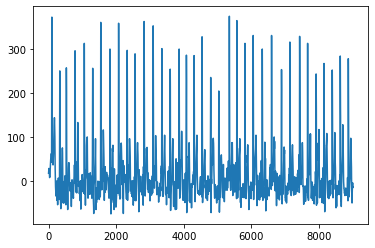

In [76]:
idx = 175

plt.plot(validation_data[idx])
print(f"label: {validation_labels[idx]} | prediction: {np.argmax(model.predict(validation_data[idx:idx+1]))}")
